In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/elephant-picture/african_elephants.jpg


In [22]:
#視覺化類別激活熱圖 heatmap of class activation
#找出影像中使convnet做出最終分類決策的部分，並看到各物件對類別激活的程度
#類別激活圖(class activation map)(CAM)的視覺化: 
#依輸入影像，取得卷積層的輸出特徵圖，然後以 "各channel對某類別之梯度值(重要程度)" 加權 "輸入影像對各channel激活之強度"的2D分數網格圖
#                                產生 "某張圖激活某類別之強度"的2D分數圖

In [23]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16

In [24]:
model = VGG16(weights='imagenet') #在頂部包含密集連接的分類器(預設include_top=True)

2022-08-21 17:46:45.057897: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [25]:
#預先處理VGG16的輸入影像
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

img_path = "../input/elephant-picture/african_elephants.jpg"
img = image.load_img(img_path, target_size=(224, 224))
print(type(img))
print(img.size)

x = image.img_to_array(img) #將PIL物件轉為float32的Numpy陣列
print(x.shape)

x = np.expand_dims(x, axis=0)

x = preprocess_input(x) #預處理批次量，對每一channel做顏色值正規化

<class 'PIL.Image.Image'>
(224, 224)
(224, 224, 3)


In [26]:
#預測圖片類別，並將預設向量解碼為可讀的影像格式
preds = model.predict(x)
print('預測結果:', decode_predictions(preds, top=3)[0])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


預測結果: [('n02504458', 'African_elephant', 0.90942097), ('n01871265', 'tusker', 0.08618304), ('n02504013', 'Indian_elephant', 0.0043546236)]


In [27]:
np.argmax(preds[0]) #在啟動函數預測向量的各元素中，數值最高的元素為386對應到"非洲象"類別

386

In [28]:
#設定Grad-CAM演算法
#為了看出影像中哪部分最像非洲象
from tensorflow.keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

african_elephant_output = model.output[:, 386] #預測向量中屬於"非洲象"類別的元素

last_conv_layer = model.get_layer('block5_conv3') #VGG16最後一個卷積層block5_conv3的輸出特徵圖

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0] #block5_conv3的輸出特徵圖中關於"非洲象"類別的梯度

pooled_grads = K.mean(grads, axis=(0, 1, 2)) #轉換成向量shape=(512,)，其中每個項目是特定特徵圖channel的梯度平均強度(值)

iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x]) #給定大象樣本影像產生梯度向量和輸出向量，以Numpy陣列呈現

#將 "特徵圖陣列中每個channel" 與 "每個channel對大象類別之梯度值(重要程度)" 相乘
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1) #特徵圖的跨channel平均值是類別激活函數輸出的熱圖

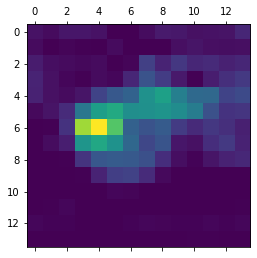

In [30]:
#熱圖後期處理
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [34]:
#將熱圖與原圖疊合
import cv2

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255 * heatmap) #將熱圖轉換為RGB

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) #將熱圖疊加至原圖上

superimposed_img = heatmap * 0.4 + img #0.4為熱圖強度因子

cv2.imwrite('elephant_cam.jpg', superimposed_img)

True